# Filtracja bilateralna

## Konwolucja obrazu z filtrem o zadanych współczynnikach

Splot (konwolucję) obrazu wejściowego $I$ z filtrem $\psi$ dla ustalonego punktu obrazu $\mathbf{x}$ można przedstawić następująco:

\begin{equation}
\hat{I}(\mathbf{x}) = \frac{1}{W_N}\sum_{\mathbf{p} \in \eta(\mathbf{x})} \psi(||\mathbf{p}-\mathbf{x}||)I(\mathbf{p})
\end{equation}

gdzie:
- $\hat{I}$ jest obrazem wynikowym (przefiltrowanym),
- $W_N = \sum_y \psi(y)$ jest parametrem normalizującym współczynniki filtra $\psi$,
- $||\cdot||$ jest odległością między punktami obrazu $\mathbf{x}$ i $\mathbf{p}$ według ustalonej metryki (np. norma $L_2$). Uwaga, proszę pamiętać, że zarówno $\mathbf{x}$, jak i $\mathbf{p}$ to współrzędne przestrzenne,
- $\eta(\mathbf{x})$ jest otoczeniem punktu $\mathbf{x}$.

Funkcja $\psi$ decyduje o charakterze filtracji. Dla filtru Gaussowskiego:

\begin{equation}
\psi(y) = G_{\delta_s}(y)
\end{equation}

gdzie: $G_{\delta_s}(y)$ jest funkcją Gaussa z parametrem skali $\delta_s$.

Opisaną powyżej filtrację realizowaliśmy w ramach ćwiczenia "Przetwarzanie wstępne. Filtracja kontekstowa."

## Filtracja bilateralna

Wadą klasycznego splotu jest brak adaptacji współczynników filtra do lokalnego otoczenia $\eta(\mathbf{x})$ filtrowanego punktu $\mathbf{x}$.
Oznacza to wykorzystanie tych samych współczynników filtra $\psi$ niezależnie od tego czy otoczenie jest względnie jednorodne lub zawiera krawędzie obiektów (w tym przypadku dochodzi do "rozmywania" krawędzi).
Filtracja bilateralna uwzględnia lokalne otoczenie filtrowanego punktu, w ten sposób, że parametry filtra zmieniają się w zależności od "wyglądu" otocznia.


Współczynniki filtra obliczane są na podstawie odległości filtrowanego punktu $\mathbf{x}$ od każdego punktu otoczenia $\mathbf{p}$ w dziedzinie przestrzennej obrazu (tak jak przy typowym filtrze np. Gaussa) oraz odległości punktów w przeciwdziedzinie obrazu (np. na podstawie różnicy w jasności pikseli dla obrazu w odcieniach szarości):

\begin{equation}
\hat{I}(\mathbf{x}) = \frac{1}{W_N}\sum_{\mathbf{p} \in \eta(\mathbf{x})} \psi(||\mathbf{p}-\mathbf{x}||) \gamma(|I(\mathbf{p}) - I(\mathbf{x})|) I(\mathbf{p})
\end{equation}
gdzie:
- $W_N$ jest współczynnikiem normalizującym filtr,
- $\gamma$ jest funkcją odległości w przeciwdziedzinie obrazu, np. $\gamma(y)=\exp(-\frac{y^2}{2\delta_r^2})$
- parametr $\delta_r$ jest utożsamiany z poziomem szumu w obrazie i należy go dobrać w sposób empiryczny.

Proszę chwilę zastanowić się nad powyższym równaniem, w szczególności nad funkcją $\gamma$. Proszę wyznaczyć, jaka będzie wartość funkcji dla pikseli podobnych (różnica 0, 1, 2), a skrajnie różnych (255, 200).

##  Realizacja ćwiczenia

### Wczytanie danych

1. Wczytaj dane z pliku *MR_data.mat*. W tym celu wykorzystaj funkcję `loadmat` z pakietu scipy:
        from scipy.io import loadmat
        mat = loadmat('MR_data.mat')

2. Wczytany plik zawiera 5 obrazów: *I_noisefree*, *I_noisy1*, *I_noisy2*, *I_noisy3* oraz *I_noisy4*. Odczytać je można w następujący sposób:
        Input = mat['I_noisy1']

3.Wyświetl wybrany obraz z pliku *MR_data.mat*. Zagadka - co to za obrazowanie medyczne?

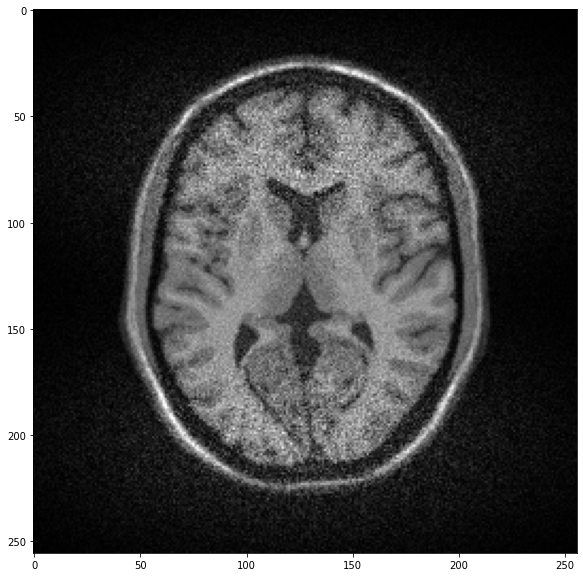

In [ ]:
import cv2
import os
import requests
from matplotlib import pyplot as plt
import numpy as np
from scipy import signal
from scipy.io import loadmat
import math

url = 'https://raw.githubusercontent.com/vision-agh/poc_sw/master/07_Bilateral/'

fileNames = ["MR_data.mat"]
for fileName in fileNames:
  if not os.path.exists(fileName):
      r = requests.get(url + fileName, allow_redirects=True)
      open(fileName, 'wb').write(r.content)

mat = loadmat("MR_data.mat")
I = mat["I_noisy2"]

fig, axs = plt.subplots(1, 1)
fig.set_size_inches(10, 10)
axs.imshow(I, cmap="gray", vmin=0, vmax=255)
plt.show()

### "Klasyczna" konwolucja

1. Zdefiniuj parametry filtra Gaussowskiego: rozmiar okna i wariancję $\delta_S$.
2. Oblicz współczynniki filtra na podstawie zdefiniowanych parametrów (najprościej w ramach podwójnej pętli for).
2. Sprawdź ich poprawność i zwizualizuj filtr (tak jak w ćwiczeniu pt. "Przetwarzanie wstępne. Filtracja kontekstowa.").
3. Wykonaj kopię obrazu wejściowego: `IConv = Input.copy()`
4. Wykonaj podwójną pętlę po obrazie. Pomiń ramkę, dla której nie jest zdefiniowany kontekst o wybranej wielkości.
5. W każdej iteracji stwórz dwuwymiarową tablicę zawierającą aktualny kontekst.
6. Napisz funkcję, która będzie obliczała nową wartość piksela.
Argumentem tej funkcji są aktualnie przetwarzane okno i współczynniki filtra.
7. Obliczoną wartość przypisz do odpowiedniego piksela kopii obrazu wejściowego.
8. Wyświetl wynik filtracji.
9. Porównaj wynik z obrazem oryginalnym.

[[0.04495104 0.08755267 0.10934005 0.08755267 0.04495104]
 [0.08755267 0.17052931 0.21296534 0.17052931 0.08755267]
 [0.10934005 0.21296534 0.26596152 0.21296534 0.10934005]
 [0.08755267 0.17052931 0.21296534 0.17052931 0.08755267]
 [0.04495104 0.08755267 0.10934005 0.08755267 0.04495104]]


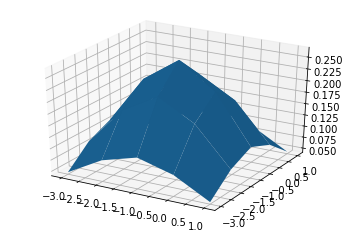

In [ ]:
from scipy.stats import norm

def gaussian_window(size, sigma):
    middle_x, middle_y = size // 2, size // 2
    window = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            distance = np.linalg.norm([middle_x - i, middle_y - j])
            window[i, j] = norm.pdf(distance, loc=0, scale=sigma)
    return window


def mesh(fun, size):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    

    X = np.arange(-size//2, size//2, 1)
    Y = np.arange(-size//2, size//2, 1)
    X, Y = np.meshgrid(X, Y)
    Z = fun
    
    ax.plot_surface(X, Y, Z)
    
    plt.show()

win_size = 5
variance = 1.5

gauss = gaussian_window(win_size, variance)
print(gauss)
mesh(gauss, 5)

In [ ]:
def gaussian_filter(I, win_size, sigma):
    window = gaussian_window(win_size, sigma)
    result = I.copy().astype(np.float32)
    for i in range(win_size // 2, I.shape[0] - win_size // 2):
        for j in range(win_size // 2, I.shape[1] - win_size // 2):
            result[i, j] = np.sum(I[i - win_size // 2:i + win_size // 2 + 1, j - win_size // 2:j + win_size // 2 + 1] * window)
    
    return (result / window.sum()).astype(np.uint8)

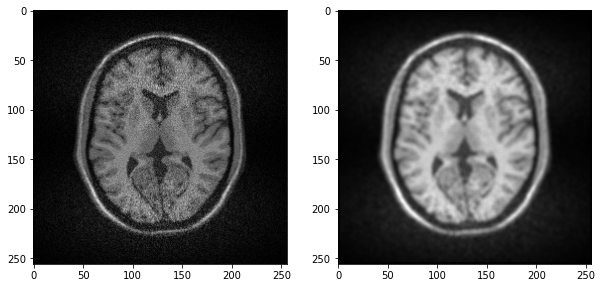

In [ ]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(10, 10)
axs[0].imshow(I, cmap="gray")
axs[1].imshow(gaussian_filter(I, 5, 2), cmap="gray")
plt.show()

### Filtracja bilateralna

1. Zdefiniuj dodatkowy parametr: wariancję $\delta_R$.
3. Wykonaj kopię obrazu wejściowego: `IBilateral = Input.copy()`
4. Wykonaj podwójną pętlę po obrazie. Pomiń ramkę, dla której nie jest zdefiniowany kontekst o wybranej wielkości.
5. W każdej iteracji stwórz dwuwymiarową tablicę zawierającą aktualny kontekst.
6. Napisz funkcję, która będzie obliczała nową wartość piksela.
Argumentami funkcji są aktualnie przetwarzane okno, współczynniki filtra gausowskiego (takie same jak wcześniej) i wariancja $\delta_R$.
7. Oblicz odległość w przeciwdziedzinie (dla wartości pikseli).
8. Oblicz funkcję Gaussa dla obliczonych odległości z zadanym parametrem.
9. Wykonaj normalizację obliczonych współczynników.
10. Obliczoną wartość przypisz do odpowiedniego piksela kopii obrazu wejściowego.
11. Wyświetl wynik filtracji.
12. Porównaj wynik z obrazem oryginalnym.

In [ ]:
def bilateral_filter(I, win_size, sigma, sigma_r):
    def gamma_func(y):
        y = np.int64(y)
        return np.exp(-(y ** 2) / (2 * sigma_r * sigma_r))
    
    def gamma_window(I_window, v, window):
        result = np.zeros((win_size, win_size))
        for i in range(win_size):
            for j in range(win_size):
                result[i, j] = window[i, j] * gamma_func(v - I_window[i, j])
        return result / result.sum()

    window = gaussian_window(win_size, sigma)
    result = I.copy().astype(np.float32)
    for i in range(win_size // 2, I.shape[0] - win_size // 2):
        for j in range(win_size // 2, I.shape[1] - win_size // 2):
            I_window = I[i - win_size // 2:i + win_size // 2 + 1, j - win_size // 2:j + win_size // 2 + 1]
            result[i, j] = np.sum(I_window * gamma_window(I_window, I[i, j], window))
    
    return result.astype(np.uint8)

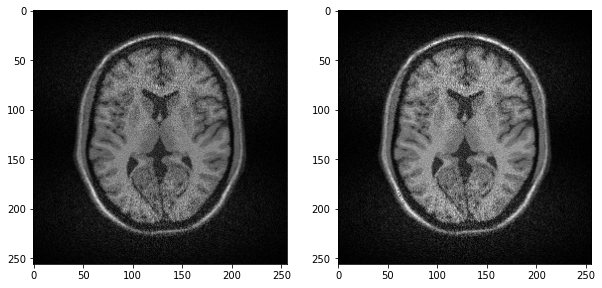

In [ ]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(10, 10)
axs[0].imshow(I, cmap="gray")
axs[1].imshow(bilateral_filter(I, 5, 2, 0.1), cmap="gray")
plt.show()

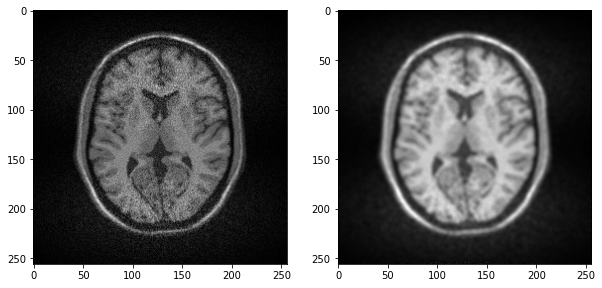

In [ ]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(10, 10)
axs[0].imshow(I, cmap="gray")
axs[1].imshow(bilateral_filter(I, 5, 2, 10000), cmap="gray")
plt.show()

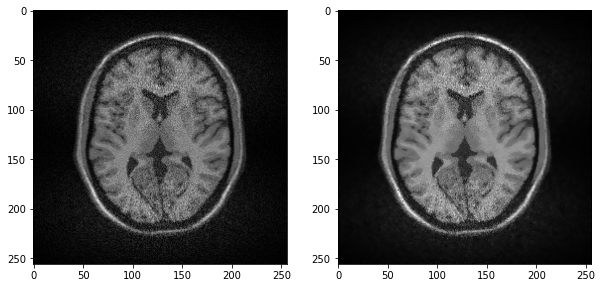

In [ ]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(10, 10)
axs[0].imshow(I, cmap="gray")
axs[1].imshow(bilateral_filter(I, 5, 2, 15), cmap="gray")
plt.show()